# Import libraries


##In this colab, model has been built using NYC taxi dataset. We predict taxi fare by taking refrence from the colab provided in instructions.

In [ ]:
## import libraries

#PyTorch 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
from torchvision import models
from torch.nn import init
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing


#other
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import math 
from google.colab import files
import io
import datetime as dt
import re
import pandas_profiling
import pandas_profiling as pp
from math import sqrt

#graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import pylab as plt
import matplotlib.dates as dates
import seaborn as sns
import pylab
import matplotlib
import matplotlib.dates
from IPython.display import display
import plotly.graph_objects as go


%matplotlib inline

In [ ]:
# load tqdm
#!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm, tqdm_notebook, tnrange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Help Functions

In [ ]:
def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

# Upload Data

In [ ]:
# upload df_train csv file

uploaded = files.upload()
df_train = pd.read_csv(io.BytesIO(uploaded['sub_train.csv']))


Saving sub_train.csv to sub_train (1).csv


In [ ]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
# upload df_Test csv file

uploaded = files.upload()
df_test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
df_test.head()

Saving test.csv to test (2).csv


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


# Data preprocessing

## Stacking train and test set so that they undergo the same preprocessing

In [ ]:
# copy for subbmision

df_test_for_sub = df_test['key']
df_test_for_sub

0       2015-01-27 13:08:24.0000002
1       2015-01-27 13:08:24.0000003
2       2011-10-08 11:53:44.0000002
3       2012-12-01 21:12:12.0000002
4       2012-12-01 21:12:12.0000003
                   ...             
9909    2015-05-10 12:37:51.0000002
9910    2015-01-12 17:05:51.0000001
9911    2015-04-19 20:44:15.0000001
9912    2015-01-31 01:05:19.0000005
9913    2015-01-18 14:06:23.0000006
Name: key, Length: 9914, dtype: object

In [ ]:
# delete the fares that are less than 0
df_train = df_train.loc[df_train.fare_amount > 0]
df_train.fare_amount.min()

0.01

In [ ]:
len(df_train)

249979

In [ ]:
train_X = df_train.drop(columns=['fare_amount'])
Y = np.log(df_train.fare_amount)

#Y = df_train['fare_amount']
test_X = df_test


In [ ]:
train_X.shape

(249979, 7)

In [ ]:
test_X.shape

(9914, 7)

In [ ]:
df = train_X.append(test_X,sort=False)

In [ ]:
df.shape

(259893, 7)

##Calculate the distance traveled

In [ ]:
#from sklearn.metrics.pairwise import haversine_distance
df['dist_km'] = haversine_distance(df,'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


##Add a datetime column and derive useful statistics

In [ ]:
df['EDTdate'] = pd.to_datetime(df['pickup_datetime'].str[:19]) - pd.Timedelta(hours=4)
df['Hour'] = df['EDTdate'].dt.hour
df['AMorPM'] = np.where(df['Hour']<12,'am','pm')
df['Weekday'] = df['EDTdate'].dt.strftime("%a")
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009-06-15 13:26:21,13,pm,Mon
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010-01-05 12:52:16,12,pm,Tue
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011-08-17 20:35:00,20,pm,Wed
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012-04-21 00:30:42,0,am,Sat
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010-03-09 03:51:00,3,am,Tue


In [ ]:
df.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dist_km              0
EDTdate              0
Hour                 0
AMorPM               0
Weekday              0
dtype: int64

In [ ]:
df=df.dropna()

# Prepare the model

## Defining Categorical and Continuous columns

In [ ]:
cat_cols = ['Hour', 'AMorPM', 'Weekday']
cont_cols = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']


In [ ]:
#df.head()
#df.info()

In [ ]:
#make the cat categories as "category" and label encoder it.
for col in df.columns:
  if col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])
    df[col]= df[col].astype('category')



In [ ]:
df.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPM,Weekday
0,2009-06-15 17:26:21.0000001,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009-06-15 13:26:21,13,1,1
1,2010-01-05 16:52:16.0000002,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010-01-05 12:52:16,12,1,5
2,2011-08-18 00:35:00.00000049,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,2011-08-17 20:35:00,20,1,6
3,2012-04-21 04:30:42.0000001,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,2012-04-21 00:30:42,0,0,2
4,2010-03-09 07:51:00.000000135,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,2010-03-09 03:51:00,3,0,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259891 entries, 0 to 9913
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   key                259891 non-null  object        
 1   pickup_datetime    259891 non-null  object        
 2   pickup_longitude   259891 non-null  float64       
 3   pickup_latitude    259891 non-null  float64       
 4   dropoff_longitude  259891 non-null  float64       
 5   dropoff_latitude   259891 non-null  float64       
 6   passenger_count    259891 non-null  int64         
 7   dist_km            259891 non-null  float64       
 8   EDTdate            259891 non-null  datetime64[ns]
 9   Hour               259891 non-null  category      
 10  AMorPM             259891 non-null  category      
 11  Weekday            259891 non-null  category      
dtypes: category(3), datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 20.6+ MB


##Drop irrelevent columns for the Model and Split into train and test

In [ ]:
df.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'dist_km',
       'EDTdate', 'Hour', 'AMorPM', 'Weekday'],
      dtype='object')

In [ ]:
# keep only the cols for the model
df = df[['Hour', 'AMorPM', 'Weekday','pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]

In [ ]:
df_train = df[:249979]
df_test = df[249979:]

##Continuous values

In [ ]:
#Normalizing 

from pandas.api.types import is_numeric_dtype

#"Compute the means and stds of `self.cont_names` columns to normalize them."
def Normalize(df):
  means,stds = {},{}
  cont_names = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']
  for n in cont_names:
    assert is_numeric_dtype(df[n]), (f"""Cannot normalize '{n}' column as it isn't numerical. Are you sure it doesn't belong in the categorical set of columns?""")
    means[n],stds[n] = df[n].mean(),df[n].std()
    df[n] = (df[n]-means[n]) / (1e-7 + stds[n])


Normalize(df_train)
Normalize(df_test)
X = df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
0,13,1,1,0.084500,-0.114733,0.118104,-0.123607,-0.522701,-0.050455
1,12,1,5,0.083434,-0.129662,0.128620,-0.136549,-0.522701,-0.030396
2,20,1,6,0.088753,-0.126767,0.123878,-0.137675,0.242205,-0.049485
3,0,0,2,0.085759,-0.127148,0.125014,-0.137705,-0.522701,-0.045674
4,3,0,5,0.089470,-0.125494,0.128885,-0.134423,-0.522701,-0.047837


In [ ]:
X.shape

(249979, 9)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 249979 entries, 0 to 1
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Hour               249979 non-null  category
 1   AMorPM             249979 non-null  category
 2   Weekday            249979 non-null  category
 3   pickup_latitude    249979 non-null  float64 
 4   pickup_longitude   249979 non-null  float64 
 5   dropoff_latitude   249979 non-null  float64 
 6   dropoff_longitude  249979 non-null  float64 
 7   passenger_count    249979 non-null  float64 
 8   dist_km            249979 non-null  float64 
dtypes: category(3), float64(6)
memory usage: 14.1 MB


## train-valid split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42,shuffle=True ) 
X_train.head()

,Hour,AMorPM,Weekday,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,dist_km
24163,2,0,0,0.086699,-0.126605,0.126492,-0.134980,-0.522701,-0.044407
2508,11,0,4,0.087860,-0.126639,0.125205,-0.136110,-0.522701,-0.050771
71038,9,0,2,0.090772,-0.124200,0.126495,-0.134637,-0.522701,-0.049314
67576,8,0,5,0.090493,-0.124729,0.125006,-0.136112,-0.522701,-0.046399
187028,22,1,2,0.089375,-0.126875,0.122877,-0.131308,0.242205,-0.037810


## Embeddings

In [ ]:
#df.info()
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(24, 12), (2, 1), (7, 4)]

In [ ]:
type(emb_szs)

list

In [ ]:
X_train.shape


(199983, 9)

In [ ]:
X_val.shape

(49996, 9)

In [ ]:
y_train.shape

(199983,)

In [ ]:
y_val.shape

(49996,)

#Model

##Pytorch data set datasets and dataloaders

In [ ]:
class RegressionColumnarDataset(data.Dataset):
    def __init__(self, df, cats, y):
        
        
        self.dfcats = df[cats] #type: pandas.core.frame.DataFrame
        self.dfconts = df.drop(cats, axis=1) #type: pandas.core.frame.DataFrame
        
        
        self.cats = np.stack([c.values for n, c in self.dfcats.items()], axis=1).astype(np.int64) #tpye: numpy.ndarray
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32) #tpye: numpy.ndarray
        self.y = y.values.astype(np.float32)
        
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        
        return [self.cats[idx], self.conts[idx], self.y[idx]]
        
        

In [ ]:
trainds = RegressionColumnarDataset(X_train, cat_cols, y_train) #type: __main__.RegressionColumnarDataset
valds = RegressionColumnarDataset(X_val, cat_cols, y_val) #type: __main__.RegressionColumnarDataset

In [ ]:
params = {'batch_size': 128,
          'shuffle': True}


traindl = DataLoader(trainds, **params) #type: torch.utils.data.dataloader.DataLoader
valdl = DataLoader(valds, **params) #type: torch.utils.data.dataloader.DataLoader

In [ ]:
traindl

##Tabular Model

In [ ]:
# help functions

from collections.abc import Iterable


def bn_drop_lin(n_in:int, n_out:int, bn:bool=True, p:float=0., actn=None):
    "Sequence of batchnorm (if `bn`), dropout (with `p`) and linear (`n_in`,`n_out`) layers followed by `actn`."
    layers = [nn.BatchNorm1d(n_in)] if bn else []
    if p != 0: layers.append(nn.Dropout(p))
    layers.append(nn.Linear(n_in, n_out))
    if actn is not None: layers.append(actn)
    return layers

def ifnone(a,b):
    "`a` if `a` is not None, otherwise `b`."
    return b if a is None else a

def listify(p, q):
    "Make `p` listy and the same length as `q`."
    if p is None: p=[]
    elif isinstance(p, str):          p = [p]
    elif not isinstance(p, Iterable): p = [p]
    #Rank 0 tensors in PyTorch are Iterable but don't have a length.
    else:
        try: a = len(p)
        except: p = [p]
    n = q if type(q)==int else len(p) if q is None else len(q)
    if len(p)==1: p = p * n
    assert len(p)==n, f'List len mismatch ({len(p)} vs {n})'
    return list(p)

              

class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs, n_cont:int, out_sz:int, layers, ps=None,
                 emb_drop:float=0., y_range=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) #type: torch.nn.modules.container.ModuleList
        self.emb_drop = nn.Dropout(emb_drop) #type: torch.nn.modules.dropout.Dropout
        self.bn_cont = nn.BatchNorm1d(n_cont) #type torch.nn.modules.batchnorm.BatchNorm1d
        n_emb = sum(e.embedding_dim for e in self.embeds) # n_emb = 17 , type: int
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = [n_emb + n_cont] + layers + [out_sz] #typeL list, len: 4
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None] #type: list, len: 3.  the last in None because we finish with linear
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers) #type: torch.nn.modules.container.Sequential
        



    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)] #take the embedding list and grab an embedding and pass in our single row of data.        
            x = torch.cat(x, 1) # concatenate it on dim 1 ## remeber that the len is the batch size
            x = self.emb_drop(x) # pass it through a dropout layer
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont) # batchnorm1d
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont # combine the categircal and continous variables on dim 1
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0] # deal with y_range
        return x.squeeze()
    

In [ ]:
torch.manual_seed(33)

In [ ]:
y_range = (0, y_train.max()*1.2)
y_range

(0, 7.445469315082428)

In [ ]:
model = TabularModel(emb_szs = emb_szs,n_cont = len(cont_cols),out_sz = 1,layers = [1000,500,250],ps= [0.001,0.01,0.01],emb_drop=0.04, y_range=y_range).to(device)
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=23, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01, inplace=False)
    (8): Linear(in_features=500, out_features=250, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.01, inplace=False)
    (12): Linear(in_features=250, out_features=1, bias=

## optimizer

In [ ]:
from collections import defaultdict
opt = torch.optim.Adam(model.parameters(), lr=1e-2) # can add: weight_decay=
#lr_cosine = lr_scheduler.CosineAnnealingLR(opt,T_max = 350) #1000 ## if you want to add lr_cosine



lr = defaultdict(list)
tloss = defaultdict(list)
vloss = defaultdict(list)

##Train and Fit

In [ ]:
def inv_y(y): return np.exp(y)

def rmse(targ, y_pred):
    return np.sqrt(mean_squared_error(inv_y(y_pred), inv_y(targ))) #.detach().numpy()
    

def rmse(targ, y_pred):
   return np.sqrt(mean_squared_error(y_pred, targ)) #.detach().numpy()


#def fit(model, train_dl, val_dl, loss_fn, opt, scheduler, epochs=3): ## if you want to add schedular
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=3):
    num_batch = len(train_dl)
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0          
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        for cat, cont, y in t:
            cat = cat.cuda()
            cont = cont.cuda()
            y = y.cuda()
            
            t.set_description(f'Epoch {epoch}')
            
            opt.zero_grad() #find where the grads are zero
            pred = model(cat, cont)
            loss = loss_fn(pred, y)
            
            loss.backward() # do backprop
            lr[epoch].append(opt.param_groups[0]['lr'])
            tloss[epoch].append(loss.item())
            opt.step()
            #scheduler.step()
            
            
            t.set_postfix(loss=loss.item())
            
            y_true_train += list(y.cpu().data.numpy())
            y_pred_train += list(pred.cpu().data.numpy())
            total_loss_train += loss.item()
            
        train_acc = rmse(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl) # len train_dl = 704. the calc is number of train examples (89991) / batch size (128)
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
            for cat, cont, y in tqdm_notebook(val_dl, leave=False):
                cat = cat.cuda()
                cont = cont.cuda()
                y = y.cuda()
                pred = model(cat, cont)
                loss = loss_fn(pred, y)
                
                y_true_val += list(y.cpu().data.numpy())
                y_pred_val += list(pred.cpu().data.numpy())
                total_loss_val += loss.item()
                vloss[epoch].append(loss.item())
            valacc = rmse(y_true_val, y_pred_val)
            valloss = total_loss_val/len(valdl)
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f} | val_loss: {valloss:.4f} val_rmse: {valacc:.4f}')
        else:
            print(f'Epoch {epoch}: train_loss: {train_loss:.4f} train_rmse: {train_acc:.4f}')
    
    return lr, tloss, vloss

## Train the model

In [ ]:
#if you want to add lr_cosine
#lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt, scheduler=lr_cosine, epochs=10)


lr, tloss, vloss = fit(model=model, train_dl=traindl, val_dl=valdl, loss_fn=nn.MSELoss(), opt=opt,  epochs=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 0: train_loss: 0.4085 train_rmse: 0.6391 | val_loss: 0.3416 val_rmse: 0.5845


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 1: train_loss: 0.3203 train_rmse: 0.5660 | val_loss: 0.3208 val_rmse: 0.5665


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 2: train_loss: 0.3136 train_rmse: 0.5601 | val_loss: 0.3123 val_rmse: 0.5589


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 3: train_loss: 0.3072 train_rmse: 0.5543 | val_loss: 0.3075 val_rmse: 0.5545


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 4: train_loss: 0.3065 train_rmse: 0.5537 | val_loss: 0.3086 val_rmse: 0.5555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 5: train_loss: 0.3061 train_rmse: 0.5532 | val_loss: 0.3081 val_rmse: 0.5551


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 6: train_loss: 0.3066 train_rmse: 0.5537 | val_loss: 0.3085 val_rmse: 0.5555


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 7: train_loss: 0.3068 train_rmse: 0.5538 | val_loss: 0.3094 val_rmse: 0.5562


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 8: train_loss: 0.3076 train_rmse: 0.5547 | val_loss: 0.3162 val_rmse: 0.5623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Epoch 9: train_loss: 0.3081 train_rmse: 0.5551 | val_loss: 0.3080 val_rmse: 0.5550



## Plots

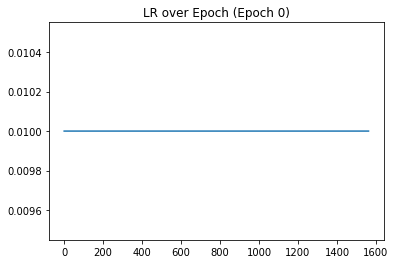

In [ ]:
#Plot the Learning rate
_ = plt.plot(lr[0])
_ = plt.title('LR over Epoch (Epoch 0)')

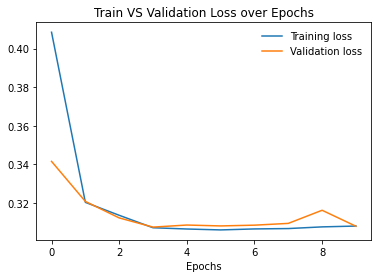

In [ ]:
#inspired from: https://nbviewer.jupyter.org/github/FraPochetti/KagglePlaygrounds/blob/master/NYC%20Taxi%20Fares%20Prediction.ipynb 
# Train VS Validaton Loss

t = [np.mean(tloss[el]) for el in tloss]
v = [np.mean(vloss[el]) for el in vloss]

plt.plot(t, label='Training loss')
plt.plot(v, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("Epochs")
plt.legend(frameon=False)

# Test 

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9912 entries, 2 to 9913
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Hour               9912 non-null   category
 1   AMorPM             9912 non-null   category
 2   Weekday            9912 non-null   category
 3   pickup_latitude    9912 non-null   float64 
 4   pickup_longitude   9912 non-null   float64 
 5   dropoff_latitude   9912 non-null   float64 
 6   dropoff_longitude  9912 non-null   float64 
 7   passenger_count    9912 non-null   float64 
 8   dist_km            9912 non-null   float64 
dtypes: category(3), float64(6)
memory usage: 572.4 KB


In [ ]:
# divide to cats and conts columns + make them a tensor + to.cuda()

df_test_cats = df_test[['Hour', 'AMorPM', 'Weekday']]
test_cats = df_test_cats.astype(np.int64)
test_cats = torch.tensor(test_cats.values).cuda()

df_test_conts = df_test[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'dist_km']]
test_conts = df_test_conts.astype(np.float32)
test_conts = torch.tensor(test_conts.values).cuda()

In [ ]:
# make prediction

with torch.no_grad():
    model.eval()
    output = model.forward(test_cats,test_conts).cuda()

In [ ]:
output

tensor([2.2199, 2.0848, 2.4333,  ..., 2.7276, 2.5444, 1.9365], device='cuda:0')

In [ ]:
len(output)

9912

In [ ]:
type(output)

torch.Tensor

In [ ]:
# convert to numpy array
np_output = output.cpu().numpy()

In [ ]:
type(np_output)

numpy.ndarray

In [ ]:
np_output

array([2.219875 , 2.0847578, 2.4333007, ..., 2.727586 , 2.5443685,
       1.9365021], dtype=float32)

In [ ]:
#  exp to the output data

np_output_exp = np.exp(np_output)

In [ ]:
np_output_exp

array([ 9.206182,  8.042644, 11.396436, ..., 15.295918, 12.735183,
        6.934452], dtype=float32)

In [ ]:
# CONVERT to pandas data frame 

df_output =  pd.DataFrame(np_output_exp)

In [ ]:
df_output

,0
0,9.206182
1,8.042644
2,11.396436
3,9.663917
4,7.263952
...,...
9907,8.516577
9908,9.761715
9909,15.295918
9910,12.735183


In [ ]:
type(df_output)

pandas.core.frame.DataFrame

In [ ]:
#output file

df_output.to_csv('submission.csv', index=False)


In [ ]:
# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)

from IPython.display import HTML
import base64

def create_download_link(df, title = "Download CSV file", filename = "submission.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

In [ ]:
# create a link to download the dataframe
create_download_link(df_output)